In [25]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
from numpy import linalg as LA
from scipy.spatial import distance
import math

def get_laplacians(x, n_agents, rr, ro, ra, n_neighbors):
    A_r = np.zeros((n_agents, n_agents))
    D_r = np.zeros((n_agents, n_agents))
    A_o = np.zeros((n_agents, n_agents))
    D_o = np.zeros((n_agents, n_agents))
    A_a = np.zeros((n_agents, n_agents))
    D_a = np.zeros((n_agents, n_agents))
    
    if metric == "dist":
        for i in range(n_agents):
            for j in range(n_agents):
                if i == j:
                    continue
                dist = np.sum((x[j] - x[i]) ** 2) ** 0.5
                if dist < rr:
                    A_r[i, j] = 1
                    #A_r[j, i] = 1
                    D_r[i, i] += 1
                elif dist < ro:
                    A_o[i, j] = 1
                    #A_o[j, i] = 1
                    D_o[i, i] += 1
                elif dist < ra:
                    A_a[i, j] = 1
                    #A_a[j, i] = 1
                    D_a[i, i] += 1
    return D_r, A_r, D_o, A_o, D_a, A_a

def get_fiedler_ev(mtx):
    eig_vals = LA.eigvals(mtx)
    eig_vals = np.sort(eig_vals)
    non_zero = eig_vals[eig_vals>1e-10]
    if len(non_zero)==0:
        return 0
    else:
        #print(non_zero[0], eig_vals[1])
        return non_zero[0]

def is_visible(x, x_angles, point_idx, nn_idx, fop):
    # Get direction of neighbor in relation to point
    v = (x[nn_idx] - x[point_idx]) / LA.norm(x[nn_idx] - x[point_idx])
    # Get angle between neighbor direction and point orientation
    angle = np.arccos(np.dot(x_angles[point_idx], v) /
                          (np.linalg.norm(x_angles[point_idx]) * np.linalg.norm(v)))
    if angle <= (fop / 2.0):
        return True
    else:
        return False
    
def target_angles(x, x_angles, r_r, r_o, r_a, fop, n_neighbors=None):
    D = distance.squareform(distance.pdist(x))
    sorted_idx = np.argsort(D, axis=1)
    target_angles = np.copy(x_angles)
    # Each node now has a list of its neighbors sorted by distance
    for point_idx in range(x.shape[0]):
        nn = 1
        dist = 0
        no_repulsors, orient, attractors = True,False,False
        target_angle = np.zeros((x.shape[1]))
        has_neighbors = False
        # Iterate over neighbors until they are out of perception range (farther than ZOA reaches)
        while True:
            if nn == sorted_idx.shape[0]:
                break
                
            nn_idx = sorted_idx[point_idx, nn]
            dist = D[point_idx, nn_idx]
            if is_visible(x, x_angles, point_idx, nn_idx, fop):
                if dist < r_r:
                    no_repulsors = False
                    target_angle -= (x[nn_idx] - x[point_idx]) / LA.norm(x[nn_idx] - x[point_idx])
                # Neighbors in ZOO and ZOA only take effect if there is no one in the zone of repulsion
                elif dist < r_o and no_repulsors:
                    orient = True
                    target_angle += x_angles[nn_idx] / LA.norm(x_angles[nn_idx])
                elif dist < r_a and no_repulsors:
                    attractors = True
                    target_angle += (x[nn_idx] - x[point_idx]) / LA.norm(x[nn_idx] - x[point_idx]) 
                else: 
                    break
                nn += 1
                if n_neighbors is not None:
                    n_neighbors -= 1
                    if n_neighbors == 0:
                        break
            else:
                nn += 1
                continue
        
        if not no_repulsors:
            target_angles[point_idx] = target_angle
        elif orient and attractors:
            # if there are neighbors in both attraction radius and orientation radius, 
            # take average between the two
            target_angles[point_idx] = target_angle / 2
        elif orient or attractors:
            target_angles[point_idx] = target_angle

    return target_angles


def get_angle(vector1=None,vector2=None):
    if vector1 is None:
        vector1 = np.asarray([1,0])
    sign = np.sign(np.cross(vector1, vector2))
    angle = sign*np.arccos(np.dot(vector1, vector2) /
                          (np.linalg.norm(vector1) * np.linalg.norm(vector2)+1e-6))
    if angle==0 and (np.sign(vector1)!=np.sign(vector2)).any():
        angle=math.pi
    return angle

def unit_vector(vector):
    return vector/LA.norm(vector)

def rotate(x_angles, t_angles, turning_rate, tau=.1):
    # Turning rate: turning rate * tau (timestep) - can we scale this to be from 0 to 1?
    tau_turning_rate = tau * turning_rate

    for i in range(x_angles.shape[0]):

        # angle from direction to target direction -pi to pi
        angle = get_angle(x_angles[i], t_angles[i])

        # if vectors are completely opposite
        if abs(angle)<1e-6 and (np.sign(x_angles[i]) != np.sign(t_angles[i])).any():
            angle=math.pi

        if abs(angle) <= tau_turning_rate:
            x_angles[i] = t_angles[i]
        elif abs(angle) > tau_turning_rate:
            old_angle =get_angle(None,x_angles[i])
            c = min(1,tau_turning_rate/abs(angle))
            t = old_angle+angle*c
            new_vector = math.cos(t), math.sin(t)
            x_angles[i]=new_vector

    return x_angles

def move_agents(x, x_angles, velocity, tau):
    x += x_angles * velocity * tau
    return x

def plot_evs(fiedler_r, fiedler_o, fiedler_a, avg_deg_r, avg_deg_o, avg_deg_a):
    %matplotlib inline
    
    fig = plt.figure()
    ax = fig.add_subplot(2,3,1)
    ax.plot(fiedler_r)
    ax.set_title("Fiedler EV of Repulsion Laplacian")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Fiedler EV of L_r")
    
    fig = plt.figure()
    ax = fig.add_subplot(2,3,2)
    ax.plot(fiedler_o)
    ax.set_title("Fiedler EV of Orientation Laplacian")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Fiedler EV of L_o")

    fig = plt.figure()
    ax = fig.add_subplot(2,3,3)
    ax.plot(fiedler_a)
    ax.set_title("Fiedler EV of Attraction Laplacian")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Fiedler EV of L_a")

    fig = plt.figure()
    ax = fig.add_subplot(2,3,4)
    ax.plot(avg_deg_r)
    ax.set_title("Average Degree of Repulsion Matrix")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Avg Degree of D_r")
    
    fig = plt.figure()
    ax = fig.add_subplot(2,3,5)
    ax.plot(avg_deg_o)
    ax.set_title("Average Degree of Orientation Matrix")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Avg Degree of D_o")

    fig = plt.figure()
    ax = fig.add_subplot(2,3,6)
    ax.plot(avg_deg_a)
    ax.set_title("Average Degree of Attraction Matrix")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Avg Degree of D_a")
    plt.show()

<IPython.core.display.Javascript object>


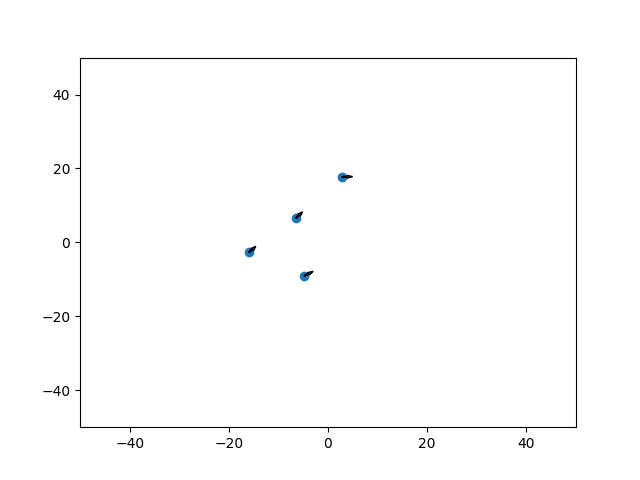

ValueError: not enough values to unpack (expected 6, got 4)

In [26]:
%matplotlib notebook
n_agents = 4
world_dim = 100
M = world_dim / 4
n_neighbors = None
metric = "nn" # "dist","nn"
n_timesteps = 10000
turning_rate = (50 / 360.0) * 2 * math.pi # 100 degrees to radians. Is tune-able
fop = (225 / 360.0) * 2 * math.pi # 270 degrees field of perception
velocity = 1
tau = 0.1
r_r = 1
r_o = r_r * 3
r_a = r_r * 9

def plot(n_agents=4, world_dim=100, M=world_dim/4,n_neighbors=5,metric="nn",n_timesteps=10000,turning_rate = (50 / 360.0) * 2 * math.pi, fop = (225 / 360.0) * 2 * math.pi, velocity = 1, tau = 0.1, r_r = 1, r_o=3, r_a=9):

    x = 2 * M * (np.random.random((n_agents, 2)) - 0.5)
    x_angles = np.random.random((n_agents, 2))
    x_angles = x_angles / LA.norm(x_angles, axis=1)[:,None] # direction vectors are unit vectors

    
    plot = True
    fiedler_r = []
    avg_deg_r = []
    fiedler_o = []
    avg_deg_o = []
    fiedler_a = []
    avg_deg_a = []

    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.show()

    #target_angles(x, x_angles, r_r, r_o, r_a, fop)

    t_angles = None
    for step in range(n_timesteps):
        ax.clear()
        ax.scatter(x[:,0], x[:,1])
        for n in range(n_agents):
            ax.arrow(x[n,0],x[n,1],x_angles[n,0],x_angles[n,1], width=.25)
        if t_angles is not None:
            for n in range(n_agents):
                ax.arrow(x[n,0],x[n,1],t_angles[n,0],t_angles[n,1], width=.25, color="Blue")
        ax.set_xlim((-world_dim / 2,world_dim / 2))
        ax.set_ylim((-world_dim / 2,world_dim / 2))
        fig.canvas.draw()

        D_r, A_r, D_o, A_o, D_a, A_a = get_laplacians(x, n_agents, r_r, r_o, r_a, n_neighbors)
        t_angles = target_angles(x, x_angles, r_r, r_o, r_a, fop, n_neighbors)
        t_angles = t_angles / LA.norm(t_angles, axis=1)[:,None]
        x_angles = rotate(x_angles, t_angles, turning_rate, tau)
        x_angles = x_angles / LA.norm(x_angles, axis=1)[:,None]
        x = move_agents(x, x_angles, velocity, tau)
        x = (x+2*M)%(4*M)-2*M # wrap agents around
        
        L_r = D_r - A_r
        L_o = D_o - A_o
        L_a = D_a - A_a
        fiedler_r.append(get_fiedler_ev(L_r))
        iedler_o.append(get_fiedler_ev(L_o))
        fiedler_a.append(get_fiedler_ev(L_a))
        avg_deg_r.append(np.mean(D_r.diagonal()))
        avg_deg_o.append(np.mean(D_o.diagonal()))
        avg_deg_a.append(np.mean(D_a.diagonal()))

        plt.pause(.05)

    if plot:
        plot_evs(fiedler_r, fiedler_o, fiedler_a, avg_deg_r, avg_deg_o, avg_deg_a)
    print("Done")

plot()

<IPython.core.display.Javascript object>


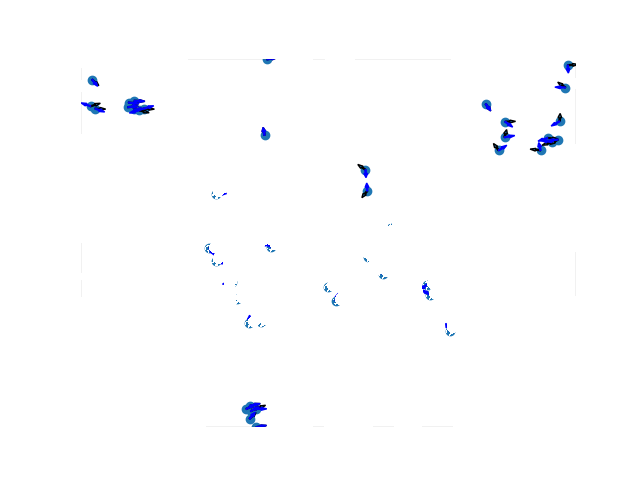

KeyboardInterrupt: 

In [24]:
%matplotlib notebook
n_agents = 30
world_dim = 100
M = world_dim / 4
n_neighbors = None
metric = "dist" # "dist","nn"
n_timesteps = 1000
turning_rate = (10 / 360.0) * 2 * math.pi # 100 degrees to radians. Is tune-able
fop = (350 / 360.0) * 2 * math.pi # 270 degrees field of perception
velocity = 1
tau = 0.5
r_r = 1
r_o = r_r * 3
r_a = r_r * 12

plot(n_agents, world_dim, M,n_neighbors,metric,n_timesteps,turning_rate, fop, velocity,tau, r_r,r_o,r_a)

NameError: name 'fiedler_r' is not defined

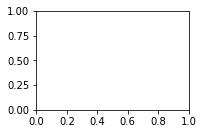

In [7]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.plot(fiedler_r)
ax.set_title("Fiedler EV of Repulsion Laplacian")
ax.set_xlabel("Timestep")
ax.set_ylabel("Fiedler EV of L_r")

fig = plt.figure()
ax = fig.add_subplot(2,2,2)
ax.plot(fiedler_a)
ax.set_title("Fiedler EV of Attraction Laplacian")
ax.set_xlabel("Timestep")
ax.set_ylabel("Fiedler EV of L_a")

fig = plt.figure()
ax = fig.add_subplot(2,2,3)
ax.plot(avg_deg_r)
ax.set_title("Average Degree of Repulsion Matrix")
ax.set_xlabel("Timestep")
ax.set_ylabel("Avg Degree of D_r")

fig = plt.figure()
ax = fig.add_subplot(2,2,4)
ax.plot(avg_deg_a)
ax.set_title("Average Degree of Attraction Matrix")
ax.set_xlabel("Timestep")
ax.set_ylabel("Avg Degree of D_a")